In [ ]:
# TODO
# - https://en.wikipedia.org/wiki/Multicollinearity#Detection_of_multicollinearity
# - https://en.wikipedia.org/wiki/Cook%27s_distance (http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html)
# - https://en.wikipedia.org/wiki/Leverage_(statistics)#Linear_regression_model

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
import statsmodels.api as sm
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("../../data/bike/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# count distinct
{col: df[col].nunique() for col in df.columns}

{'instant': 731,
 'dteday': 731,
 'season': 4,
 'yr': 2,
 'mnth': 12,
 'holiday': 2,
 'weekday': 7,
 'workingday': 2,
 'weathersit': 3,
 'temp': 499,
 'atemp': 690,
 'hum': 595,
 'windspeed': 650,
 'casual': 606,
 'registered': 679,
 'cnt': 696}

In [4]:
# completeness
{col: 1-df[col].isna().mean() for col in df.columns}

{'instant': 1.0,
 'dteday': 1.0,
 'season': 1.0,
 'yr': 1.0,
 'mnth': 1.0,
 'holiday': 1.0,
 'weekday': 1.0,
 'workingday': 1.0,
 'weathersit': 1.0,
 'temp': 1.0,
 'atemp': 1.0,
 'hum': 1.0,
 'windspeed': 1.0,
 'casual': 1.0,
 'registered': 1.0,
 'cnt': 1.0}

In [52]:
def _numeric_transformer(X):
    return pd.DataFrame([X]).T

col_encoders = {
#     'temp': Pipeline(
#                 # StandardScaler needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'temp': Pipeline(
                # StandardScaler needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
    'workingday': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
    ),
#     'holiday': Pipeline(
#                 # OneHotEncoder needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
#     ),
    'weathersit': Pipeline(
                # OneHotEncoder needs a 2d np.array
                [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True))]
                 #('scaler', StandardScaler())]
    ),
#     'season': Pipeline(
#                 # OneHotEncoder needs a 2d np.array
#                 [('wrapper', FunctionTransformer(_numeric_transformer, validate=False, accept_sparse=True)),
# #                  ('scaler', OneHotEncoder(categories='auto'))
#                 ('scaler', StandardScaler())]
#     ),
}

columns = ['temp', 'workingday', 'weathersit']#['temp', 'hum', 'workingday', 'holiday']#, 'weathersit', 'season']

transformers = ColumnTransformer([(col, col_encoders[col], col) for col in columns])

# estimator = SGDRegressor('squared_loss', max_iter=1000, tol=1e-6)
estimator = LinearRegression()

model = Pipeline([('transformers', transformers), ('estimator', estimator)])
model

Pipeline(memory=None,
     steps=[('transformers', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('temp', Pipeline(memory=None,
     steps=[('wrapper', FunctionTransformer(accept_sparse=True, check_inverse=True,
          func=<function _numeri...timator', LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False))])

In [53]:
# OneHotEncoder(categories='auto', sparse=False).fit_transform(df.head()[['weekday']])

In [54]:
model.fit(df[columns], df['cnt'])
model.named_steps['estimator'].coef_

array([6325.42062001,  181.6880878 , -810.50679145])

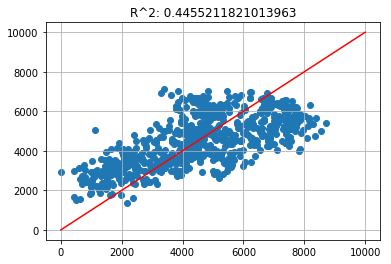

In [55]:
m = 1e4
plt.scatter(df['cnt'], model.predict(df))
plt.title('R^2: ' + str(model.score(df[columns], df['cnt'])))
plt.plot([0, m], [0, m], c='red')
plt.grid(True)

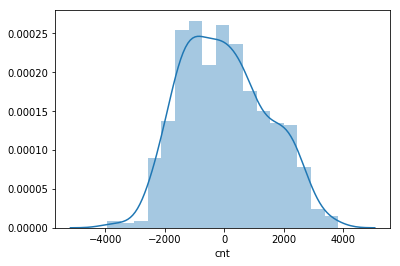

In [56]:
res = df['cnt'] - model.predict(df)
sns.distplot(res)

In [57]:
# from scipy import stats
# # https://en.wikipedia.org/wiki/Normal_probability_plot
# stats.probplot(res, plot=plt);
# plt.grid(True)

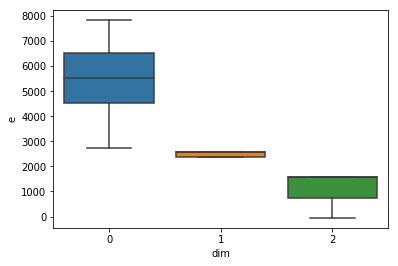

In [58]:
# effect plot
# predictions
# y = (model.named_steps['transformers'].transform(df) * model.named_steps['estimator'].coef_.reshape(-1, 1) + model.named_steps['estimator'].intercept_).squeeze()


X = model.named_steps['transformers'].transform(df)
dfs = []
for i in range(X.shape[1]):
    e = np.multiply(X[:, i], model.named_steps['estimator'].coef_[i]) + model.named_steps['estimator'].intercept_
    effect = pd.DataFrame({'e': e.squeeze()})
    effect.loc[:, 'dim'] = i
    dfs.append(effect)

effects = pd.concat(dfs)
effects.head()
sns.boxplot(x='dim', y='e', data=effects)

In [61]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html
# sm.OLS(df['cnt'], X).fit().summary()